# Several Sentences Dataset example

In [1]:
import sys
sys.path.append("../../my_lib/src/Quantum")
sys.path.append("../../my_lib/src/DataPreparation")

In [2]:

import pandas as pd
import json
import matplotlib.pyplot as plt

import random
import dictionary
import sentence
import Optimizer as optimizer
import loader
import Circuit as circuit

## Processing the .json file and preparing the dataset

Several datasets are found in the Dataset folder. 
In the complete dataset, three types of sentences are found:
* NOUN-TVERB-NOUN
* NOUN-IVERB
* NOUN-IVERB-PREP-NOUN

In the dataset used in this notebook example, only transitive sentences are used and the vocabulary is modified from the original Data Preparation module files.



In [3]:
filename = 'Expanded_Transitive_dataset.json'
Dftrain, Dftest = loader.createdf("../../my_lib/src/Quantum/Datasets/"+filename)#Dataframe form Json file
#Several datasets are found in the Dataset folder. 
#In the complete dataset, three types of sentences are found:
# 

Myvocab = loader.getvocabdict(Dftrain, Dftest)#A dictionary with word and categories found in dataset

MyDict = dictionary.QuantumDict(qn=1,#Number of qubits for noun category. 
                                qs=1)#Number of qubits for sentence category
MyDict.addwords(myvocab=Myvocab)
MyDict.setvocabparams()#Randomly assign params to words following and ansatz structure.

In [4]:
Dftrain.head()

,sentence,sentence_type,truth_value,sentence_type_code
0,dog eats bone,NOUN-TVERB-NOUN,True,0
1,mouse eats fish,NOUN-TVERB-NOUN,False,0
2,cat eats bone,NOUN-TVERB-NOUN,True,0
3,bird flees cat,NOUN-TVERB-NOUN,True,0
4,dog flees mouse,NOUN-TVERB-NOUN,False,0


In [5]:
Dftest.head()

,sentence,sentence_type,truth_value,sentence_type_code
0,dog chases mouse,NOUN-TVERB-NOUN,True,0
1,bird eats bird,NOUN-TVERB-NOUN,False,0
2,cat eats dog,NOUN-TVERB-NOUN,False,0
3,cat chases mouse,NOUN-TVERB-NOUN,True,0
4,dog eats meat,NOUN-TVERB-NOUN,True,0


-----
For creating the sentences the following ansatz was used.
* qn = 1
* qs = 1

More qubits are shown in the circuit figure for a better understanding of Ansatz shape
<img src="SentenceAnsatz.png">

In [6]:
def createsentencelist(dftrain, mydict):
    sentences_list = []
    for i, DataInstance in dftrain.iterrows():
        a_sentence = sentence.Sentence(DataInstance,
                                       dataset=True,
                                       dictionary=mydict)

        a_sentence.getqbitcontractions()
        a_sentence.setparamsfrommodel(mydict)
        sentences_list.append(a_sentence)

    return sentences_list

In [29]:
    SentencesList = createsentencelist(Dftrain, MyDict)
    SentencesList = [x for x in random.sample(SentencesList, 40)]#For some dataset that may be too big,
                                                                #we can select just a few sentences to try out
                                                                #the model parameters.
    par, ix = MyDict.getindexmodelparams()
    myopt = optimizer.ClassicalOptimizer()
    result = myopt.optimizedataset(SentencesList, par, MyDict,
                                   tol=1e-5,
                                   options={'maxiter':500, 'rhobeg': 1},
                                   method="COBYLA")

iteration 10 
 Cost: 0.4249097822351392
iteration 20 
 Cost: 0.4044928751089384
iteration 30 
 Cost: 0.5966064079766388
iteration 40 
 Cost: 0.37999511293833466
iteration 50 
 Cost: 0.3650454453377588
iteration 60 
 Cost: 0.3784365859980766
iteration 70 
 Cost: 0.34802458981037054
iteration 80 
 Cost: 0.31853631993430365
iteration 90 
 Cost: 0.3662310739525147
iteration 100 
 Cost: 0.30522736449653187
iteration 110 
 Cost: 0.30039293049231514
iteration 120 
 Cost: 0.2733249978302871
iteration 130 
 Cost: 0.26477023809905254
iteration 140 
 Cost: 0.22538271111985617
iteration 150 
 Cost: 0.22373424945826334
iteration 160 
 Cost: 0.2381827227566488
iteration 170 
 Cost: 0.21966755133512111
iteration 180 
 Cost: 0.22123338520459068
iteration 190 
 Cost: 0.21093640903698044
iteration 200 
 Cost: 0.21008400217920892
iteration 210 
 Cost: 0.20917975795126517
iteration 220 
 Cost: 0.19763485625962812
iteration 230 
 Cost: 0.1983702717620301
iteration 240 
 Cost: 0.1968089276348701
iteration 2

Text(0, 0.5, 'Cost function (Cross entropy)')

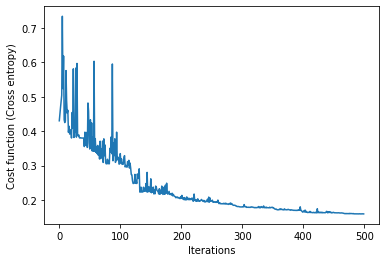

In [30]:
plt.plot(myopt.itercost)
plt.xlabel('Iterations')
plt.ylabel('Cost function (Cross entropy)')

-----------------
## Re-running the sentences of the training dataset

In [31]:
MyDict.updateparams(result.x)
SentencesList = createsentencelist(Dftrain, MyDict)

In [32]:
Dftrain_result = Dftrain.copy()
Result=[]
for i,a_sentence in enumerate(SentencesList):
    mycirc = circuit.CircuitBuilder()
    mycirc.createcircuit(a_sentence, dataset=True)
    mycirc.executecircuit()

    probs = [0, 0]
    # print('sentence: {}'.format(mysentence.sentence))
    for sample in mycirc.result:
        state = sample.state.bitstring
        postselectedqubits = ''.join(state[x] for x in range(len(state)) if x != a_sentence.sentencequbit)
        if postselectedqubits == '0' * (mycirc.qlmprogram.qbit_count - 1):
            if state[a_sentence.sentencequbit] == '0':
                probs[0] = sample.probability
                # print(
                #    "State %s: probability %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))
            elif state[a_sentence.sentencequbit] == '1':
                probs[1] = sample.probability
                # print(
                #    "State %s: probability %s, amplitude %s" % (
                #   sample.state, sample.probability, sample.amplitude))
    prob0 = probs[0] / sum(probs)
    prob1 = probs[1] / sum(probs)
    print('Sentence: {}'.format(a_sentence.sentence))
    if a_sentence.label == 0:
        print('label = False')
    elif a_sentence.label == 1:
        print('label = True')
    if prob0 >= 0.5:
        print('I found this sentence to be FALSE')
        if a_sentence.label==0:
            Result.append('Correct')
        elif a_sentence.label==1:
            Result.append('Error')
    else:
        print('I found this sentence to be TRUE')  
        if a_sentence.label==0:
            Result.append('Error')
        elif a_sentence.label==1:
            Result.append('Correct')
    print('------')
Dftrain_result['Result']=Result    


Sentence: dog eats bone
label = True
I found this sentence to be TRUE
------
Sentence: mouse eats fish
label = False
I found this sentence to be FALSE
------
Sentence: cat eats bone
label = True
I found this sentence to be TRUE
------
Sentence: bird flees cat
label = True
I found this sentence to be FALSE
------
Sentence: dog flees mouse
label = False
I found this sentence to be FALSE
------
Sentence: mouse chases dog
label = False
I found this sentence to be FALSE
------
Sentence: mouse flees cat
label = True
I found this sentence to be TRUE
------
Sentence: mouse eats mouse
label = False
I found this sentence to be TRUE
------
Sentence: mouse eats cat
label = False
I found this sentence to be FALSE
------
Sentence: mouse flees fish
label = False
I found this sentence to be TRUE
------
Sentence: cat eats mouse
label = True
I found this sentence to be TRUE
------
Sentence: bird flees dog
label = True
I found this sentence to be TRUE
------
Sentence: dog chases fish
label = False
I foun

---------
## Testing the model in the training dataset

In [33]:
MyDict.updateparams(result.x)
SentencesList = createsentencelist(Dftest, MyDict)

In [34]:
Dftest_result = Dftest.copy()
Result=[]
for a_sentence in SentencesList:
    mycirc = circuit.CircuitBuilder()
    mycirc.createcircuit(a_sentence, dataset=True)
    mycirc.executecircuit()

    probs = [0, 0]
    # print('sentence: {}'.format(mysentence.sentence))
    for sample in mycirc.result:
        state = sample.state.bitstring
        postselectedqubits = ''.join(state[x] for x in range(len(state)) if x != a_sentence.sentencequbit)
        if postselectedqubits == '0' * (mycirc.qlmprogram.qbit_count - 1):
            if state[a_sentence.sentencequbit] == '0':
                probs[0] = sample.probability
                # print(
                #    "State %s: probability %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))
            elif state[a_sentence.sentencequbit] == '1':
                probs[1] = sample.probability
                # print(
                #    "State %s: probability %s, amplitude %s" % (
                #   sample.state, sample.probability, sample.amplitude))
    prob0 = probs[0] / sum(probs)
    prob1 = probs[1] / sum(probs)
    print('Sentence: {}'.format(a_sentence.sentence))
    if a_sentence.label == 0:
        print('label = False')
    elif a_sentence.label == 1:
        print('label = True')
    if prob0 >= 0.5:
        print('I found this sentence to be FALSE')
        if a_sentence.label==0:
            Result.append('Correct')
        elif a_sentence.label==1:
            Result.append('Error')
    else:
        print('I found this sentence to be TRUE')  
        if a_sentence.label==0:
            Result.append('Error')
        elif a_sentence.label==1:
            Result.append('Correct')
    print('------')
Dftest_result['Result']=Result    


Sentence: dog chases mouse
label = True
I found this sentence to be FALSE
------
Sentence: bird eats bird
label = False
I found this sentence to be FALSE
------
Sentence: cat eats dog
label = False
I found this sentence to be TRUE
------
Sentence: cat chases mouse
label = True
I found this sentence to be FALSE
------
Sentence: dog eats meat
label = True
I found this sentence to be TRUE
------
Sentence: cat eats bird
label = True
I found this sentence to be TRUE
------
Sentence: cat chases fish
label = False
I found this sentence to be FALSE
------
Sentence: dog chases cat
label = True
I found this sentence to be FALSE
------
Sentence: dog flees cat
label = False
I found this sentence to be FALSE
------
Sentence: cat eats meat
label = True
I found this sentence to be TRUE
------
Sentence: bird chases cat
label = False
I found this sentence to be FALSE
------
Sentence: bird flees fish
label = False
I found this sentence to be FALSE
------
Sentence: mouse eats bird
label = False
I found t

------------
We now plot an histogram for the test and train dataset and see how many sentences instances have been correctly labelled and in how many the model has failed. 
We can see that we were successful with the train dataset but now with the test, which may be a sign of overfitting. 
To improve this, we need to further investigate:
* Different Ansaetze
* Different classical optimization methods
* Different datasets

train accuracy = 0.7916666666666666
test accuracy = 0.6923076923076923


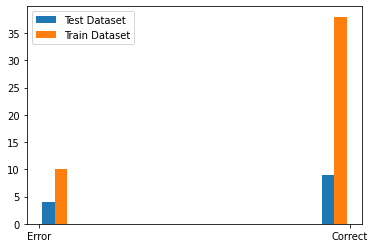

In [35]:
trainaccuracy = (Dftrain_result['Result']=='Correct').sum()/len(Dftrain_result['Result'])
testaccuracy = (Dftest_result['Result']=='Correct').sum()/len(Dftest_result['Result'])

print('train accuracy = {}'.format(trainaccuracy))
print('test accuracy = {}'.format(testaccuracy))

plt.hist([Dftest_result['Result'],Dftrain_result['Result']], label =['Test Dataset', 'Train Dataset'])
plt.legend()